In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer  # Corrected import
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix
import joblib
import shap
import streamlit as st

# Constants
RANDOM_STATE = 42

# Load dataset
file_path = 'sensor.csv'  
data = pd.read_csv(file_path)

# Validate dataset
# TODO: Add any specific data validation steps here (e.g., checking for correct datatypes, missing values beyond NaN, etc.)

# Display dataset overview
print(data.head())
print(data.describe())

   Unnamed: 0            timestamp  sensor_00  sensor_01  sensor_02  \
0           0  2018-04-01 00:00:00   2.465394   47.09201    53.2118   
1           1  2018-04-01 00:01:00   2.465394   47.09201    53.2118   
2           2  2018-04-01 00:02:00   2.444734   47.35243    53.2118   
3           3  2018-04-01 00:03:00   2.460474   47.09201    53.1684   
4           4  2018-04-01 00:04:00   2.445718   47.13541    53.2118   

   sensor_03  sensor_04  sensor_05  sensor_06  sensor_07  ...  sensor_43  \
0  46.310760   634.3750   76.45975   13.41146   16.13136  ...   41.92708   
1  46.310760   634.3750   76.45975   13.41146   16.13136  ...   41.92708   
2  46.397570   638.8889   73.54598   13.32465   16.03733  ...   41.66666   
3  46.397568   628.1250   76.98898   13.31742   16.24711  ...   40.88541   
4  46.397568   636.4583   76.58897   13.35359   16.21094  ...   41.40625   

   sensor_44  sensor_45  sensor_46  sensor_47  sensor_48  sensor_49  \
0  39.641200   65.68287   50.92593  38.194440

In [2]:
# Data Validation
# Check for correct datatypes
print(data.dtypes)

# Check for missing values beyond NaN
missing_values = data.isnull().sum()
print(missing_values)

Unnamed: 0          int64
timestamp          object
sensor_00         float64
sensor_01         float64
sensor_02         float64
sensor_03         float64
sensor_04         float64
sensor_05         float64
sensor_06         float64
sensor_07         float64
sensor_08         float64
sensor_09         float64
sensor_10         float64
sensor_11         float64
sensor_12         float64
sensor_13         float64
sensor_14         float64
sensor_15         float64
sensor_16         float64
sensor_17         float64
sensor_18         float64
sensor_19         float64
sensor_20         float64
sensor_21         float64
sensor_22         float64
sensor_23         float64
sensor_24         float64
sensor_25         float64
sensor_26         float64
sensor_27         float64
sensor_28         float64
sensor_29         float64
sensor_30         float64
sensor_31         float64
sensor_32         float64
sensor_33         float64
sensor_34         float64
sensor_35         float64
sensor_36   

In [3]:
# Clean dataset
data_cleaned = data.drop(columns=['Unnamed: 0', 'timestamp', 'sensor_15'], errors='ignore').dropna()

In [4]:
# Encode target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(data_cleaned['machine_status'])
data_cleaned['machine_status_encoded'] = y_encoded


In [5]:
# Assuming data_cleaned is your DataFrame
value_counts_dfs = {}  # A dictionary to hold the value_counts DataFrames for each column

for column in data_cleaned.columns:
    # Applying value_counts to each column in the DataFrame
    value_counts_series = data_cleaned[column].value_counts()
    
    # Convert the Series to a DataFrame
    value_counts_df = value_counts_series.reset_index()
    value_counts_df.columns = ['Unique_Value', column + '_Counts']  # Naming the columns
    
    # Storing the DataFrame in a dictionary
    value_counts_dfs[column] = value_counts_df

# Now, value_counts_dfs contains a DataFrame of value counts for each column in your original DataFrame.
# You can access the value counts for a specific column like this:
print(value_counts_dfs)

{'sensor_00':       Unique_Value  sensor_00_Counts
0         2.455556              6791
1         2.451620              6009
2         2.453588              5964
3         2.456539              5242
4         2.459491              4015
...            ...               ...
1039      2.012847                 1
1040      0.354167                 1
1041      1.015278                 1
1042      1.009375                 1
1043      2.229282                 1

[1044 rows x 2 columns], 'sensor_01':      Unique_Value  sensor_01_Counts
0       48.437500              1473
1       49.218750              1460
2       48.914930              1203
3       48.480900              1189
4       47.699650              1182
..            ...               ...
659     55.555550                 1
660     40.104164                 1
661     39.279510                 1
662     38.628471                 1
663     53.255207                 1

[664 rows x 2 columns], 'sensor_02':      Unique_Value  sensor_02_Coun

In [6]:
# Split dataset
X = data_cleaned.drop(['machine_status', 'machine_status_encoded'], axis=1)
y = data_cleaned['machine_status_encoded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=RANDOM_STATE)

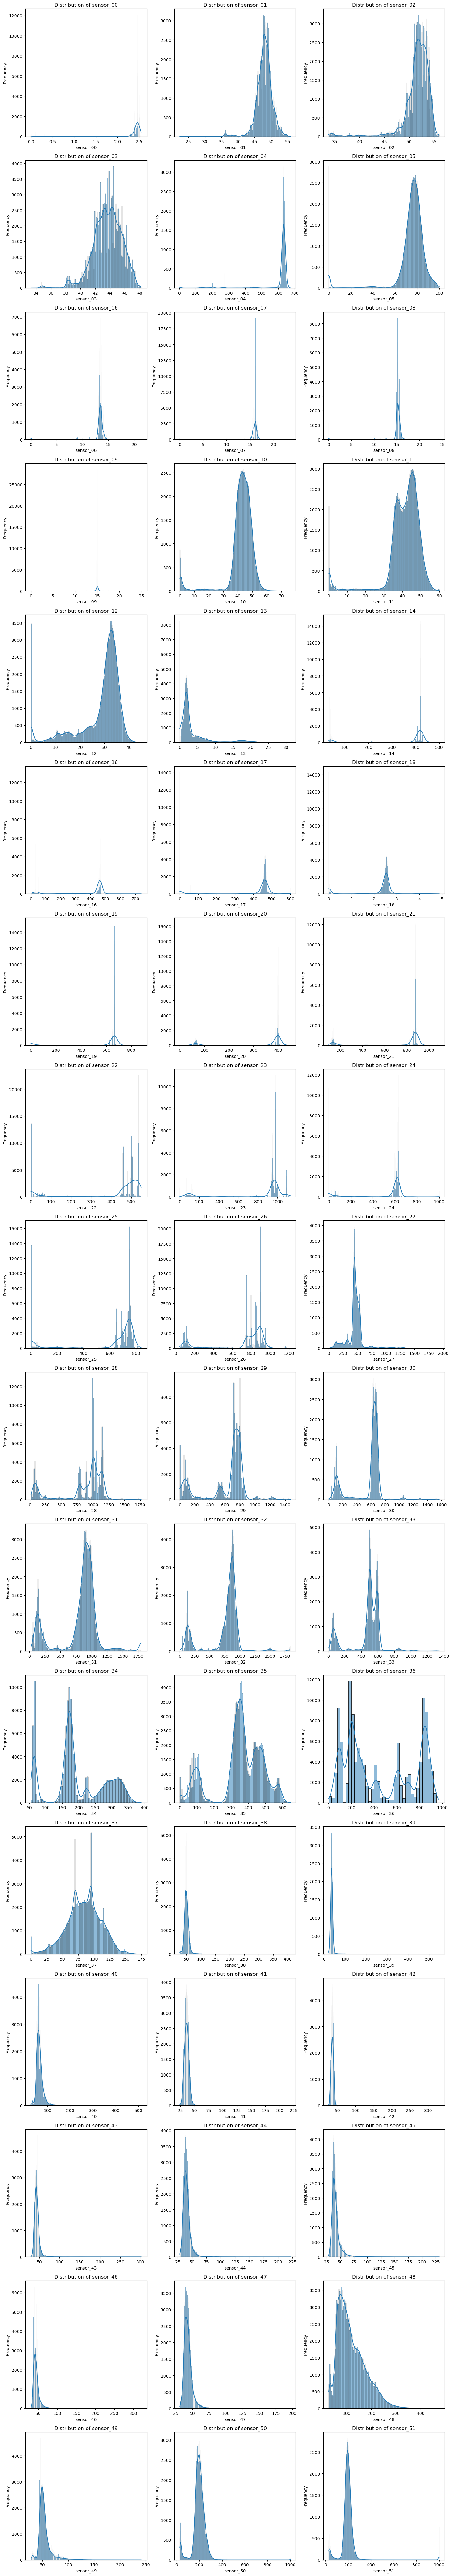

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings

# Suppress warnings
warnings.filterwarnings("ignore", message="use_inf_as_na option is deprecated")

# Replace infinite values with NaN
data_cleaned.replace([np.inf, -np.inf], np.nan, inplace=True)

# Select numeric features for visualization
numeric_features = data_cleaned.select_dtypes(include=['float64', 'int64']).columns

# Determine the number of rows and columns for subplots
num_cols = 3  # Number of columns for subplots
num_rows = (len(numeric_features) + num_cols - 1) // num_cols  # Number of rows for subplots

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))

# Plot distribution of numeric features
for i, feature in enumerate(numeric_features):
    row = i // num_cols
    col = i % num_cols
    sns.histplot(data_cleaned[feature], kde=True, ax=axes[row][col])
    axes[row][col].set_title(f'Distribution of {feature}')
    axes[row][col].set_xlabel(feature)
    axes[row][col].set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()
plt.show()


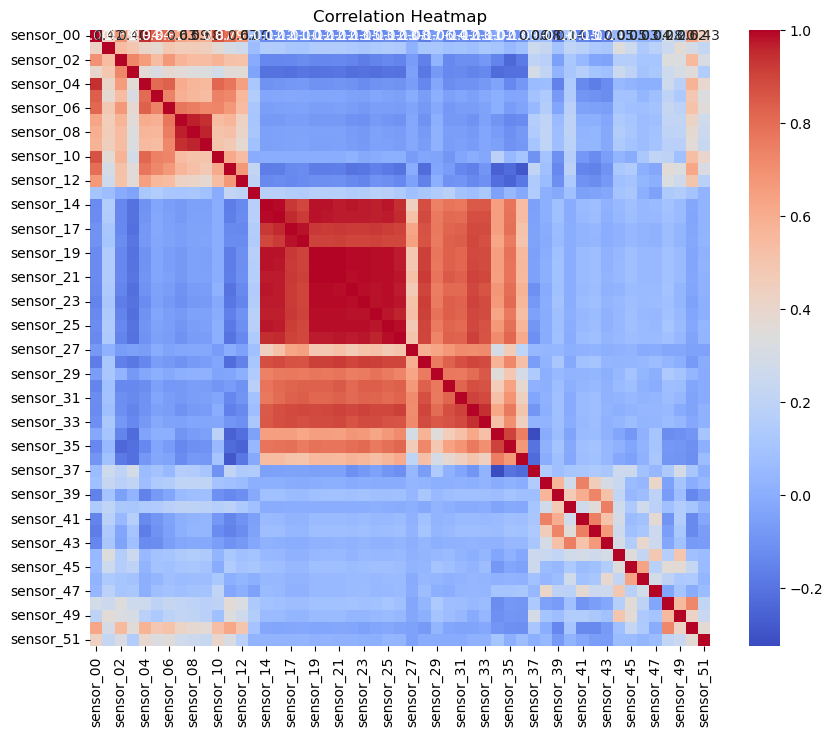

In [8]:
# Select only numeric columns for correlation calculation
numeric_columns = data_cleaned.select_dtypes(include=['float64', 'int64']).columns

# Calculate correlation matrix using only numeric columns
correlation_matrix = data_cleaned[numeric_columns].corr()

# Plot the correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()



In [9]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Epoch 1/30
2085/2085 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.9805 - loss: 0.0633 - val_accuracy: 0.9971 - val_loss: 0.0067
Epoch 2/30
2085/2085 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.9973 - loss: 0.0078 - val_accuracy: 0.9981 - val_loss: 0.0047
Epoch 3/30
2085/2085 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9981 - loss: 0.0068 - val_accuracy: 0.9989 - val_loss: 0.0033
Epoch 4/30
2085/2085 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9982 - loss: 0.0055 - val_accuracy: 0.9984 - val_loss: 0.0045
Epoch 5/30
2085/2085 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9985 - loss: 0.0047 - val_accuracy: 0.9988 - val_loss: 0.0029
Epoch 6/30
2085/2085 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9987 - loss: 0.0045 - val_accuracy: 0.9992 - val_loss: 0.0026
Epoch 7/30
2085/2085 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9987 - loss: 0.0041 - val_accuracy: 0.9988 - val_loss: 0.0029
Epoch 8/30
2085/2085 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.9988 - loss: 0.0037 - 

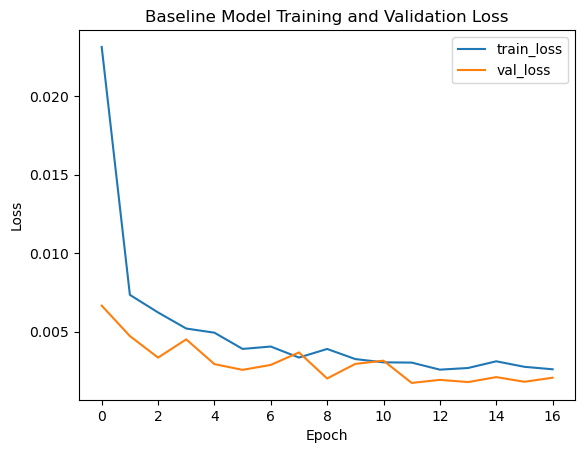

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout  # Add Input import
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt

# Define a simple feedforward neural network model
model = Sequential([
    Input(shape=(X_train_scaled.shape[1],)),  # Input layer
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(np.unique(y_train).size, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Fit the model using scaled training data
history = model.fit(
    X_train_scaled, y_train, 
    epochs=30, 
    batch_size=32, 
    validation_split=0.2,
    callbacks=[early_stopping]  # Add early stopping callback
)

# Evaluate the model using scaled test data
test_loss, test_acc = model.evaluate(X_test_scaled, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

# Plot training history
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Baseline Model Training and Validation Loss')
plt.show()

# Save the model
model.save('path_to_baseline_model.h5')  # Replace with your desired path


In [12]:
from sklearn.preprocessing import OneHotEncoder

# One-hot encode the target variable
encoder = OneHotEncoder(sparse_output=False)
y_train_encoded = encoder.fit_transform(y_train.values.reshape(-1, 1))
y_test_encoded = encoder.transform(y_test.values.reshape(-1, 1))

Epoch 1/30
2085/2085 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - auc: 0.9904 - loss: 3.8405 - precision: 0.9774 - recall: 0.9628 - val_auc: 0.9990 - val_loss: 0.0434 - val_precision: 0.9863 - val_recall: 0.9863
Epoch 2/30
2085/2085 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - auc: 0.9971 - loss: 3.8449 - precision: 0.9870 - recall: 0.9868 - val_auc: 0.9983 - val_loss: 0.0432 - val_precision: 0.9878 - val_recall: 0.9878
Epoch 3/30
2085/2085 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - auc: 0.9978 - loss: 2.8884 - precision: 0.9885 - recall: 0.9884 - val_auc: 0.9969 - val_loss: 0.0543 - val_precision: 0.9881 - val_recall: 0.9881
Epoch 4/30
2085/2085 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - auc: 0.9970 - loss: 2.2066 - precision: 0.9881 - recall: 0.9879 - val_auc: 0.9987 - val_loss: 0.0321 - val_precision: 0.9910 - val_recall: 0.9909
Epoch 5/30
2085/2085 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - auc: 0.9977 - loss: 0.5603 - precision: 0.9898 - recall: 0.9894 - val_auc: 0.9996 - val_loss: 0.0261 - val_precision: 0.9918 - val_recal


Test AUC: 0.9970481395721436, Test Precision: 0.9937869310379028, Test Recall: 0.9937869310379028


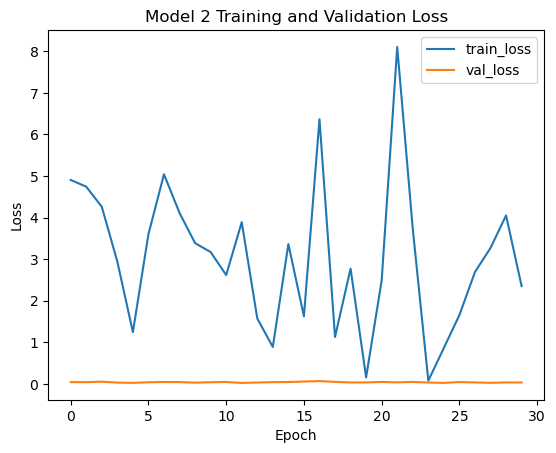

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
from keras.metrics import AUC, Precision, Recall
from sklearn.preprocessing import OneHotEncoder
import numpy as np

# Compute class weights for the encoded labels
class_weights_encoded = compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=np.argmax(y_train_encoded, axis=1)
)
class_weights_dict_encoded = dict(enumerate(class_weights_encoded))

# Define the model architecture
model_2 = Sequential([
    Input(shape=(X_train_scaled.shape[1],)),  # Use the scaled input features
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(y_train_encoded.shape[1], activation='softmax')  # Output layer size based on one-hot encoding
])

# Compile the model
model_2.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=[AUC(), Precision(), Recall()])

# Fit the model with class weights to handle imbalance
history_2 = model_2.fit(
    X_train_scaled, 
    y_train_encoded, 
    epochs=30, 
    batch_size=32, 
    class_weight=class_weights_dict_encoded, 
    validation_split=0.2  # Use a fraction of the training data for validation
)

# Evaluate the model on the test set
test_loss, test_auc, test_precision, test_recall = model_2.evaluate(X_test_scaled, y_test_encoded, verbose=2)
print(f'\nTest AUC: {test_auc}, Test Precision: {test_precision}, Test Recall: {test_recall}')

# Save the model
model_2.save('path_to_model_2.h5')  # Replace with the desired path

# Plot training history
plt.plot(history_2.history['loss'], label='train_loss')
plt.plot(history_2.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Model 2 Training and Validation Loss')
plt.show()

1117/1117 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1117/1117 ━━━━━━━━━━━━━━━━━━━━ 1s 900us/step
1117/1117 ━━━━━━━━━━━━━━━━━━━━ 1s 919us/step
1117/1117 ━━━━━━━━━━━━━━━━━━━━ 1s 835us/step
1117/1117 ━━━━━━━━━━━━━━━━━━━━ 1s 946us/step


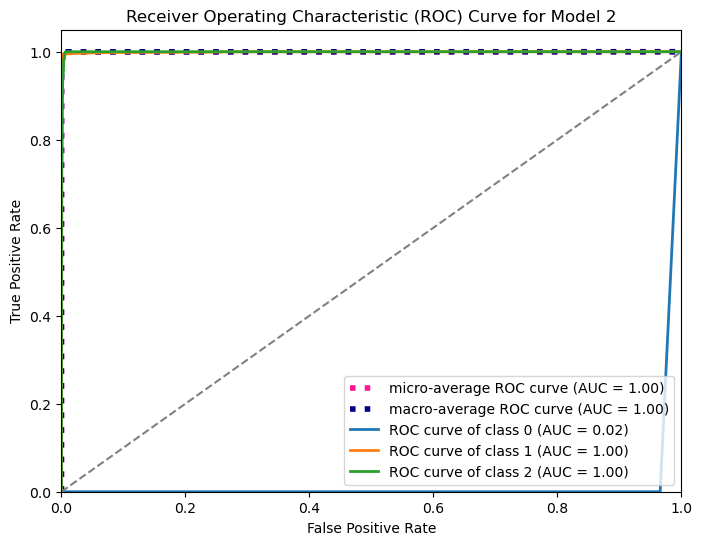

In [14]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from scipy.interpolate import interp1d

# Binarize the target variable y_test_encoded
y_test_bin_encoded = label_binarize(np.argmax(y_test_encoded, axis=1), classes=np.unique(np.argmax(y_test_encoded, axis=1)))

# Compute ROC curve and ROC area for each class using model_2
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(np.unique(np.argmax(y_test_encoded, axis=1)).size):
    y_score = model_2.predict(X_test_scaled)
    fpr[i], tpr[i], _ = roc_curve(y_test_bin_encoded[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
y_score_micro = model_2.predict(X_test_scaled)
fpr_micro, tpr_micro, _ = roc_curve(y_test_bin_encoded.ravel(), y_score_micro.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Compute macro-average ROC curve and ROC area
y_score_macro = model_2.predict(X_test_scaled)
fpr_macro, tpr_macro, _ = roc_curve(y_test_bin_encoded.ravel(), y_score_macro.ravel())
roc_auc_macro = auc(fpr_macro, tpr_macro)

# Plot ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_micro, tpr_micro, label='micro-average ROC curve (AUC = {0:0.2f})'.format(roc_auc_micro), color='deeppink', linestyle=':', linewidth=4)
plt.plot(fpr_macro, tpr_macro, label='macro-average ROC curve (AUC = {0:0.2f})'.format(roc_auc_macro), color='navy', linestyle=':', linewidth=4)

for i in range(np.unique(np.argmax(y_test_encoded, axis=1)).size):
    plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve of class {0} (AUC = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Model 2')
plt.legend(loc='lower right')
plt.show()

1117/1117 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


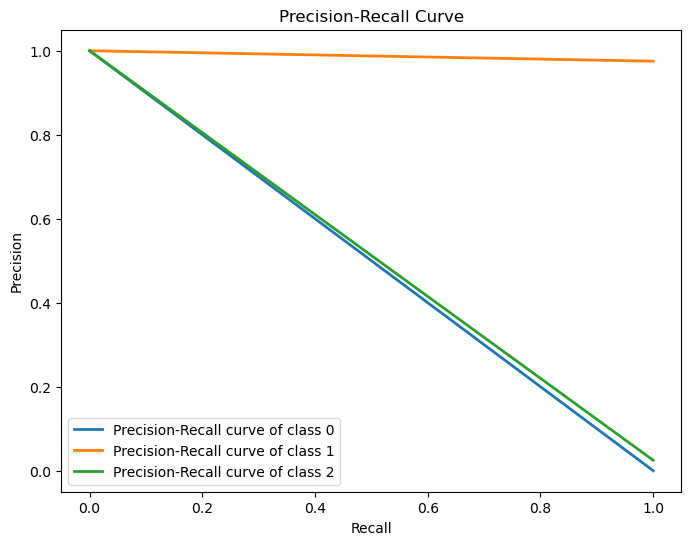

In [15]:
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Predict probabilities using the model
y_test_prob = model.predict(X_test)

# Binarize the labels
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))

# Compute precision-recall curve for each class
precision = dict()
recall = dict()
for i in range(np.unique(y_test).size):
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_test_prob[:, i])

# Plot precision-recall curves
plt.figure(figsize=(8, 6))
for i in range(np.unique(y_test).size):
    plt.plot(recall[i], precision[i], lw=2, label='Precision-Recall curve of class {0}'.format(i))

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()


Epoch 1/30
2085/2085 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - auc: 0.9970 - loss: 0.1180 - precision: 0.9900 - recall: 0.9900 - val_auc: 0.9970 - val_loss: 0.0386 - val_precision: 0.9945 - val_recall: 0.9945
Epoch 2/30
2085/2085 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - auc: 0.9968 - loss: 13.0854 - precision: 0.9896 - recall: 0.9895 - val_auc: 0.9965 - val_loss: 0.0467 - val_precision: 0.9933 - val_recall: 0.9932
Epoch 3/30
2085/2085 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - auc: 0.9968 - loss: 2.7961 - precision: 0.9897 - recall: 0.9895 - val_auc: 0.9981 - val_loss: 0.0259 - val_precision: 0.9950 - val_recall: 0.9950
Epoch 4/30
2085/2085 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - auc: 0.9964 - loss: 1.3895 - precision: 0.9889 - recall: 0.9889 - val_auc: 0.9970 - val_loss: 0.0402 - val_precision: 0.9944 - val_recall: 0.9942
Epoch 5/30
2085/2085 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - auc: 0.9979 - loss: 1.0261 - precision: 0.9927 - recall: 0.9927 - val_auc: 0.9982 - val_loss: 0.0261 - val_precision: 0.9948 - val_reca

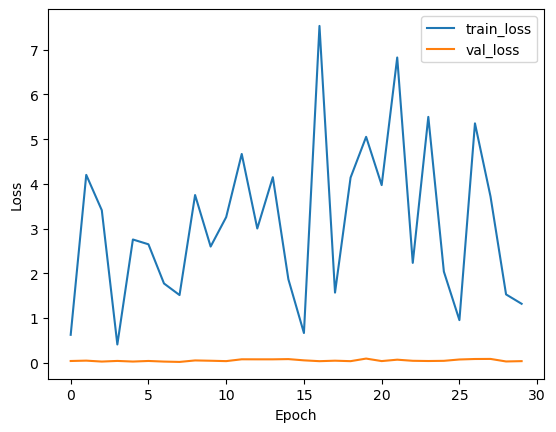

In [16]:
# Fit the model
history = model_2.fit(X_train_scaled, y_train_encoded, epochs=30, batch_size=32, class_weight=class_weights_dict_encoded, validation_split=0.2)

# Evaluate the model
test_results = model_2.evaluate(X_test_scaled, y_test_encoded, verbose=2)
test_loss = test_results[0]
test_acc = test_results[1]
print('\nTest loss:', test_loss)
print('Test accuracy:', test_acc)

# Visualize training history
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [17]:
from sklearn.preprocessing import LabelEncoder

# Flatten the one-hot encoded labels
y_train_flat = np.argmax(y_train_encoded, axis=1)
y_test_flat = np.argmax(y_test_encoded, axis=1)

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Integer encode the flattened labels
y_train_integer_encoded = label_encoder.fit_transform(y_train_flat)
y_test_integer_encoded = label_encoder.transform(y_test_flat)

In [18]:
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from kerastuner import HyperParameters

# Define the number of classes
num_classes = len(label_encoder.classes_)

# Assuming X_train_scaled and X_test_scaled are already defined and preprocessed

def build_model(hp):
    # Define input layer
    inputs = Input(shape=(X_train_scaled.shape[1],))
    
    # Define hyperparameters
    units_1 = hp.Int('units_1', min_value=32, max_value=512, step=32)
    dropout_1 = hp.Float('dropout_1', min_value=0.0, max_value=0.5, default=0.25, step=0.05)
    units_2 = hp.Int('units_2', min_value=32, max_value=512, step=32)
    dropout_2 = hp.Float('dropout_2', min_value=0.0, max_value=0.5, default=0.25, step=0.05)
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
    optimizer = hp.Choice('optimizer', ['adam', 'rmsprop', 'sgd'])

    # Define hidden layers
    x = Dense(units=units_1, activation='relu')(inputs)
    x = Dropout(dropout_1)(x)
    x = Dense(units=units_2, activation='relu')(x)
    x = Dropout(dropout_2)(x)

    # Define output layer with softmax activation for multi-class classification
    outputs = Dense(num_classes, activation='softmax')(x)

    # Construct the model
    model = Model(inputs=inputs, outputs=outputs)

    # Compile the model
    model.compile(optimizer=optimizer,
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])

    return model

C:\Users\user\AppData\Local\Temp\ipykernel_9024\2986596720.py:3: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import HyperParameters


In [19]:
from keras_tuner.tuners import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters

# Step 1: Define Hyperparameter Search Space
tuner_hp = HyperParameters()
tuner_hp.Choice('units_1', [32, 64, 128, 256, 512])
tuner_hp.Float('dropout_1', 0.0, 0.5, step=0.05)
tuner_hp.Choice('units_2', [32, 64, 128, 256, 512])
tuner_hp.Float('dropout_2', 0.0, 0.5, step=0.05)
tuner_hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')

# Step 2: Instantiate Tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='tuner_results',
    project_name='predictive_maintenance'
)

# Step 3: Search for Best Hyperparameters
tuner.search(X_train_scaled, y_train_integer_encoded, validation_split=0.2, epochs=30, batch_size=32)

# Step 4: Retrieve Best Hyperparameters
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build final model with best hyperparameters
best_model = build_model(best_hp)

# Step 5: Train and Evaluate Model
history = best_model.fit(X_train_scaled, y_train_integer_encoded, epochs=30, batch_size=32, validation_split=0.2)

# Evaluate the best model using integer-encoded labels
evaluation_results = best_model.evaluate(X_test_scaled, y_test_integer_encoded)

# Print the evaluation results
print("Test Loss:", evaluation_results[0])
print("Test Accuracy:", evaluation_results[1])

# Define a function to save the model
def save_model(model, filename):
    model_s.save('path_to_model_3.h5')

Reloading Tuner from tuner_results\predictive_maintenance\tuner0.json
Epoch 1/30
2085/2085 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.9904 - loss: 0.0330 - val_accuracy: 0.9969 - val_loss: 0.0099
Epoch 2/30
2085/2085 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.9982 - loss: 0.0064 - val_accuracy: 0.9984 - val_loss: 0.0043
Epoch 3/30
2085/2085 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.9988 - loss: 0.0032 - val_accuracy: 0.9988 - val_loss: 0.0030
Epoch 4/30
2085/2085 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - accuracy: 0.9988 - loss: 0.0043 - val_accuracy: 0.9987 - val_loss: 0.0033
Epoch 5/30
2085/2085 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.9993 - loss: 0.0025 - val_accuracy: 0.9987 - val_loss: 0.0041
Epoch 6/30
2085/2085 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.9991 - loss: 0.0033 - val_accuracy: 0.9992 - val_loss: 0.0018
Epoch 7/30
2085/2085 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.9991 - loss: 0.0048 - val_accuracy: 0.9993 - val_loss: 0.0017
Epoch 8/30
208

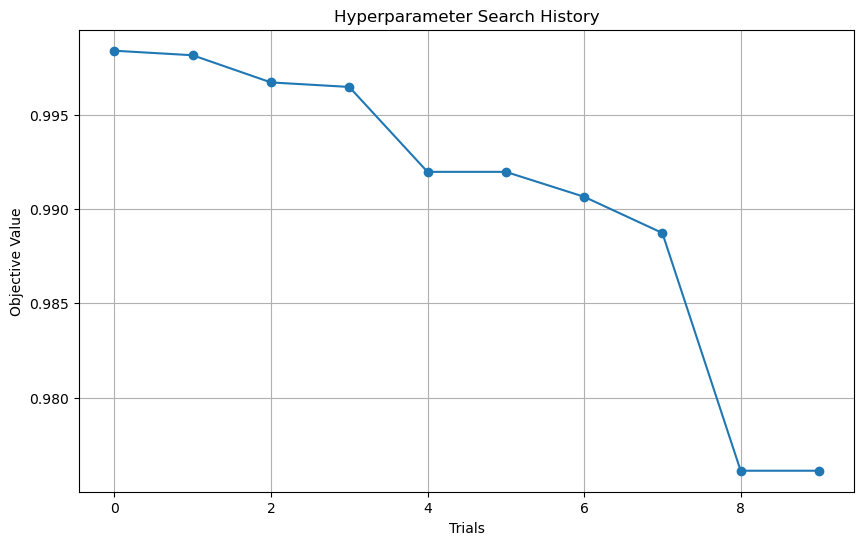

In [20]:
# Extract objective values from Trial objects
objective_values = [trial.score for trial in tuner.oracle.get_best_trials(num_trials=10)]

# Plot hyperparameter search history
plt.figure(figsize=(10, 6))
plt.plot(objective_values, marker='o')
plt.xlabel('Trials')
plt.ylabel('Objective Value')
plt.title('Hyperparameter Search History')
plt.grid(True)
plt.show()

In [21]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.base import BaseEstimator, ClassifierMixin

# Define a custom wrapper for Keras model compatible with scikit-learn
class KerasClassifierWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, build_fn, epochs=30, batch_size=32, verbose=0):
        self.build_fn = build_fn
        self.epochs = epochs
        self.batch_size = batch_size
        self.verbose = verbose
        self.model = None
    
    def fit(self, X, y):
        self.model = self.build_fn()
        self.model.fit(X, y, epochs=self.epochs, batch_size=self.batch_size, verbose=self.verbose)
        return self
    
    def predict(self, X):
        return self.model.predict_classes(X)
    
    def score(self, X, y):
        return self.model.evaluate(X, y)[1]

# Define a function to build the model
def build_model():
    model = Sequential([
        Dense(best_hp.get('units_1'), activation='relu', input_shape=(X_train_scaled.shape[1],)),
        Dropout(best_hp.get('dropout_1')),
        Dense(best_hp.get('units_2'), activation='relu'),
        Dropout(best_hp.get('dropout_2')),
        Dense(num_classes, activation='softmax')
    ])
    
    model.compile(optimizer=best_hp.get('optimizer'),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

# Create a pipeline with StandardScaler and KerasClassifierWrapper
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('keras_classifier', KerasClassifierWrapper(build_model))
])

# Perform cross-validation using StratifiedKFold for balanced classes
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(pipeline, X_train_scaled, y_train_integer_encoded, cv=kfold)

# Print cross-validation scores
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Score:", cv_scores.mean())



C:\Users\user\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


522/522 ━━━━━━━━━━━━━━━━━━━━ 1s 985us/step - accuracy: 0.9993 - loss: 0.0038


C:\Users\user\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


522/522 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9999 - loss: 0.0114


C:\Users\user\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


522/522 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9995 - loss: 0.0023


C:\Users\user\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


522/522 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9994 - loss: 0.0062


C:\Users\user\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


522/522 ━━━━━━━━━━━━━━━━━━━━ 1s 952us/step - accuracy: 0.9996 - loss: 0.0050
Cross-Validation Scores: [0.99922037 0.99988008 0.99928033 0.9995802  0.99952018]
Mean CV Score: 0.9994962334632873


In [22]:
# Define a function to save the model
def save_model(model, filename):
    model.save(filename)

# Fit the pipeline to the whole dataset
pipeline.fit(X_train_scaled, y_train_integer_encoded)

# Save the model to the specified file
save_model(pipeline.named_steps['keras_classifier'].model, 'path_to_model_cv.h5')


C:\Users\user\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [24]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score
# Ensemble Methods

# Gradient Boosting Classifier
boosting_model = GradientBoostingClassifier(n_estimators=100, random_state=RANDOM_STATE)
boosting_model.fit(X_train_scaled, y_train_integer_encoded)

# Predict on the test set
y_pred = boosting_model.predict(X_test_scaled)

# Calculate accuracy
accuracy = accuracy_score(y_test_integer_encoded, y_pred)

# Calculate precision
precision = precision_score(y_test_integer_encoded, y_pred, average='weighted')

# Calculate recall
recall = recall_score(y_test_integer_encoded, y_pred, average='weighted')

# Calculate F1-score
f1 = f1_score(y_test_integer_encoded, y_pred, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 0.999580196468053
Precision: 0.9995795936249479
Recall: 0.999580196468053
F1-score: 0.9995797664786357


In [ ]:
# Predict probabilities on the test set
y_prob = boosting_model.predict_proba(X_test_scaled)

# Calculate ROC AUC score for each class
roc_auc_per_class = roc_auc_score(y_test_integer_encodedt, y_prob, multi_class='ovr', average=None)

# Compute micro-average ROC AUC score
roc_auc_micro = roc_auc_score(y_test_integer_encoded, y_prob, multi_class='ovr', average='micro')

# Compute macro-average ROC AUC score
roc_auc_macro = roc_auc_score(y_test_integer_encoded, y_prob, multi_class='ovr', average='macro')

print("ROC-AUC Score (Micro):", roc_auc_micro)
print("ROC-AUC Score (Macro):", roc_auc_macro)
print("ROC-AUC Score (Per Class):", roc_auc_per_class)

In [ ]:
from sklearn.model_selection import cross_validate

def evaluate_model_with_metrics(model, X, y, cv=4):
    scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']
    cv_results = cross_validate(model, X, y, cv=cv, scoring=scoring)
    
    print("Cross-Validation Metrics:")
    for metric in scoring:
        print(f"{metric}: Mean = {cv_results['test_' + metric].mean():.4f}, "
              f"Std = {cv_results['test_' + metric].std():.4f}")

# Example usage:
boosting_model = GradientBoostingClassifier(n_estimators=100, random_state=RANDOM_STATE)
evaluate_model_with_metrics(boosting_model, X_train_scaled, y_train_integer_encoded, cv=4)


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

predictions = np.argmax(boosting_model.predict((X_test_scaled), axis=1)

print(classification_report(y_test_integer_encoded, predictions, zero_division=1))
print(confusion_matrix(y_test_integer_encoded, predictions))

# For more detailed metrics:
from sklearn.metrics import roc_auc_score
# Convert 'sample_y_test' to one-hot encoded labels if necessary for roc_auc_score
roc_auc = roc_auc_score(y_test_integer_encoded, boosting_model.predict((X_test_scaled), multi_class='ovr')
print("ROC AUC Score:", roc_auc)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Compute predictions
predictions = boosting_model.predict(X_test_scaled)

# Compute residuals
residuals = y_test_integer_encoded - predictions

# Plot residuals
plt.figure(figsize=(8, 6))
plt.scatter(predictions, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

In [ ]:
# Convert continuous-multioutput predictions to discrete labels
rounded_predictions = np.argmax(predictions, axis=1)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test_integer_encoded, rounded_predictions)

# Plotting the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', 
            xticklabels=np.unique(y_test_integer_encoded), 
            yticklabels=np.unique(y_test_integer_encoded))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
# Display the best model's architecture
from tensorflow.keras.utils import plot_model

plot_model(best_model, show_shapes=True)

In [ ]:
test_loss, test_acc = best_model.evaluate(X_test_scaled, y_test_integer_encoded)
print(f'\nTest Accuracy: {test_acc}, Test Loss: {test_loss}')


In [ ]:
import matplotlib.pyplot as plt

# List of model names
model_names = ['Baseline', 'Boosting', 'Stacking', 'Ensemble']

# List of model accuracies
model_accuracies = [baseline_accuracy, boosting_accuracy, stacking_accuracy, ensemble_accuracy]

# List of model losses
model_losses = [baseline_loss, boosting_loss, stacking_loss, ensemble_loss]

# List of model AUC scores
model_auc_scores = [baseline_roc_auc, boosting_roc_auc, stacking_roc_auc, ensemble_roc_auc]

# List of model test accuracies
model_test_accuracies = [baseline_test_acc, boosting_test_acc, stacking_test_acc, ensemble_test_acc]

# Plotting
plt.figure(figsize=(12, 8))

# Accuracy plot
plt.subplot(2, 2, 1)
plt.bar(model_names, model_accuracies, color='skyblue')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')

# Loss plot
plt.subplot(2, 2, 2)
plt.bar(model_names, model_losses, color='lightgreen')
plt.title('Model Loss')
plt.ylabel('Loss')

# AUC plot
plt.subplot(2, 2, 3)
plt.bar(model_names, model_auc_scores, color='salmon')
plt.title('Model AUC Score')
plt.ylabel('AUC Score')

# Test accuracy plot
plt.subplot(2, 2, 4)
plt.bar(model_names, model_test_accuracies, color='gold')
plt.title('Test Accuracy')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# FNN1 results
fnn1_accuracy = 0.9993
fnn1_loss = 0.0019
fnn1_val_accuracy = 0.9995
fnn1_val_loss = 0.0018

# FNN2 results
fnn2_auc = 0.9974
fnn2_loss = 0.0940
fnn2_precision = 0.9744
fnn2_recall = 0.9731
fnn2_test_accuracy = 0.9974021911621094

# FNNtest results
fnntest_auc = 0.9988
fnntest_loss = 0.0880
fnntest_precision = 0.9583
fnntest_recall = 0.9583
fnntest_test_accuracy = 0.998753011226654

# FNNhypertuned results
fnnhypertuned_accuracy = 0.9972
fnnhypertuned_loss = 0.007146378047764301
fnnhypertuned_test_accuracy = 0.9972852468490601

# GradientBoosting results
gradientboosting_accuracy = 0.999580196468053
gradientboosting_precision = 0.9995795936249479
gradientboosting_recall = 0.999580196468053
gradientboosting_f1_score = 0.9995797664786357
gradientboosting_roc_auc_micro = 0.9997752157752674
gradientboosting_roc_auc_macro = 0.9864818146250119
gradientboosting_roc_auc_per_class = [0.96300028, 0.99878046, 0.9976647]

# GradientBoosting cross-validation results
gradientboosting_cv_scores = [0.9995682, 0.99952022, 0.99966416, 0.99980809]
gradientboosting_mean_cv_accuracy = 0.9996401669625293
gradientboosting_std_cv_accuracy = 0.0001099308087836985

# Plotting
plt.figure(figsize=(12, 8))

# Accuracy plot
plt.subplot(2, 2, 1)
model_names = ['FNN1', 'FNN2', 'FNNtest', 'FNNhypertuned', 'GradientBoosting']
model_accuracies = [fnn1_accuracy, fnn2_test_accuracy, fnntest_test_accuracy, fnnhypertuned_test_accuracy, gradientboosting_accuracy]
plt.bar(model_names, model_accuracies, color='skyblue')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')

# Loss plot
plt.subplot(2, 2, 2)
model_losses = [fnn1_loss, fnn2_loss, fnntest_loss, fnnhypertuned_loss]
plt.bar(model_names[:-1], model_losses, color='lightgreen')
plt.title('Model Loss')
plt.ylabel('Loss')

# AUC plot
plt.subplot(2, 2, 3)
model_auc_scores = [fnn2_auc, fnntest_auc]
plt.bar(['FNN2', 'FNNtest'], model_auc_scores, color='salmon')
plt.title('Model AUC Score')
plt.ylabel('AUC Score')

# Test accuracy plot
plt.subplot(2, 2, 4)
model_test_accuracies = [fnn2_test_accuracy, fnntest_test_accuracy, fnnhypertuned_test_accuracy]
plt.bar(['FNN2', 'FNNtest', 'FNNhypertuned'], model_test_accuracies, color='gold')
plt.title('Test Accuracy')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()
